In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/zebra_fish_1000_repeats.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances
0,"[12.709163436593801, 12.671275589023288, 12.65...","[0.0025538793068670233, 0.0025554163787111033,...","[12.635944442432098, 12.635414248465437, 12.63...","[0.0025579889722140525, 0.0025580448310158032,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [7]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [8]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]


In [9]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[12.709163436593801, 12.671275589023288, 12.65...","[0.0025538793068670233, 0.0025554163787111033,...","[12.635944442432098, 12.635414248465437, 12.63...","[0.0025579889722140525, 0.0025580448310158032,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.871261,0.99219,0.985177,-5073.555287,-7871.863275,-7235.143883,pow_exp,"[-4.441328458477456e-06, -6.648448840275915e-0...",1.0


In [10]:
from matplotlib import gridspec

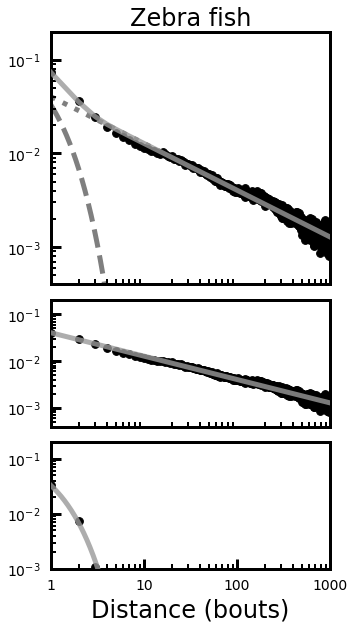

In [11]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

axi = 0
row = MI_DF.iloc[0]

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig
# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

if axi==0: 
        #ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff,0.5)

# model data
#row.concat_results.params.intercept = 0
distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)

# plot real data
ax.scatter(distances, sig, alpha = 1, s=60, color=color)   
ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)

# plot modelled data
#ax.plot(distances, y_model, alpha = 0.25, lw=10, color=color)
ax.plot(distances, y_model, alpha = 0.8, lw=5, color="#999999", zorder=10)

# plot powerlaw component
ax1 = plt.subplot(gs[1,axi])
ax = ax1
ax.plot(distances_model, y_pow-row.concat_results.params['intercept'].value, alpha = 0.8, lw=5, color="#999999", zorder=10)
ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=60, color=color)   

# plot exponential component
ax2 = plt.subplot(gs[2,axi])
ax = ax2
ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 0.8, lw=5, color="#999999", zorder=10)
ax.scatter(distances, sig-y_pow_dat, alpha = 1, s=60, color=color)   



ax.set_xlabel('Distance (bouts)', labelpad=5, fontsize=24)
#print(row.language, distances[peak_of_interest])

for ax in [ax1, ax2]:
    if axi==0: 
        #ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff,0.5)

for ax in [ax0,ax1,ax2]:
    ax.set_xlim([distances[0], distances[-1]])
    sig_lims[0] = np.log(10e-6)
    ax.set_ylim([4e-4, 0.2])
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    ax.set_xscale( "log" , basex=10)
    ax.set_yscale( "log" , basey=10)
    ax.set_xticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
#ax0.set_ylim([4e-5, 0.2])
ax2.set_ylim([10e-4, 0.2])
ax2.set_xticks([1,10,100, 1000])
ax2.set_xticklabels(['1','10','100', '1000'])

if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

gs.update(wspace=0.075, hspace=0.1)
ax0.set_title("Zebra fish", fontsize=24)
save_fig(FIGURE_DIR/'zebrafish_mi-1000-repeats')

### model output

In [12]:
from childes_mi.information_theory import model_fitting as mf

In [13]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[12.709163436593801, 12.671275589023288, 12.65...","[0.0025538793068670233, 0.0025554163787111033,...","[12.635944442432098, 12.635414248465437, 12.63...","[0.0025579889722140525, 0.0025580448310158032,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.871261,0.99219,0.985177,-5073.555287,-7871.863275,-7235.143883,pow_exp,"[-4.441328458477456e-06, -6.648448840275915e-0...",1.0


In [14]:
labels = ['Zebrafish']

### Calculate R2

In [15]:
R2 = MI_DF[['R2_exp', 'R2_concat', 'R2_power']]
R2.columns = ['exp', 'combined', 'power-law']
R2.index = labels
R2 = R2.T
R2

,Zebrafish
exp,0.871261
combined,0.992190
power-law,0.985177


### AICc

In [16]:
AICcs = MI_DF[['AICc_exp', 'AICc_concat', 'AICc_power']]
AICcs.columns = ['exp', 'combined.', 'power-law']
AICcs.index = labels
AICcs = AICcs.T
AICcs

,Zebrafish
exp,-5073.555287
combined.,-7871.863275
power-law,-7235.143883


#### $\Delta$AIC

In [17]:
delta_AICcs = AICcs.T - np.repeat(np.min(AICcs.T.values, axis=1),3).reshape(len(labels),3)
delta_AICcs = delta_AICcs.T
delta_AICcs

,Zebrafish
exp,2798.307988
combined.,0.000000
power-law,636.719392


### relative likelihood

In [18]:
relative_likelihoods = mf.relative_likelihood(delta_AICcs)
relative_likelihoods

,Zebrafish
exp,0.000000e+00
combined.,1.000000e+00
power-law,5.471932e-139


### relative probability of models

In [19]:
prob_models = mf.Prob_model_Given_data_and_models(relative_likelihoods)
prob_models

,Zebrafish
exp,0.000000e+00
combined.,1.000000e+00
power-law,5.471932e-139


#### Join tables

In [20]:
AICcs['superlabel'] = 'AICc'
relative_likelihoods['superlabel'] = 'Relative likelihood'
R2['superlabel'] = '$r^2$'
prob_models['superlabel'] = 'Relative probability'

In [21]:
results_table = pd.concat([
    AICcs,
    R2,
    relative_likelihoods,
    prob_models
]).round(3).replace(0, '<0.001').replace(1, '>0.999')
results_table[''] = results_table.index
results_table.set_index(['superlabel', ''], inplace=True)
results_table

Zebrafish
superlabel                              
AICc                 exp        -5073.56
                     combined.  -7871.86
                     power-law  -7235.14
$r^2$                exp           0.871
                     combined      0.992
                     power-law     0.985
Relative likelihood  exp          <0.001
                     combined.    >0.999
                     power-law    <0.001
Relative probability exp          <0.001
                     combined.    >0.999
                     power-law    <0.001

In [22]:
results_string = results_table.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)

\begin{tabular}{lll}
\toprule
                     &           & Zebrafish \\
\midrule
\textbf{} & {} &           \\
\midrule
\midrule
\textbf{AICc} & \textbf{exp} &  -5073.56 \\
                     & \textbf{combined.} &  -7871.86 \\
                     & \textbf{power-law} &  -7235.14 \\
\midrule
\textbf{$r^2$} & \textbf{exp} &     0.871 \\
                     & \textbf{combined} &     0.992 \\
                     & \textbf{power-law} &     0.985 \\
\midrule
\textbf{Relative likelihood} & \textbf{exp} &    $<$0.001 \\
                     & \textbf{combined.} &    $>$0.999 \\
                     & \textbf{power-law} &    $<$0.001 \\
\midrule
\textbf{Relative probability} & \textbf{exp} &    $<$0.001 \\
                     & \textbf{combined.} &    $>$0.999 \\
                     & \textbf{power-law} &    $<$0.001 \\
\bottomrule
\end{tabular}

